# Predicción de caudales extremos en Chile

### Carga y análisis de la data

Analiza el dataset caudal_extra.csv. ¿Qué puedes decir de los datos, distribuciones, missing, u otros? ¿Hay algo que te llame la atención? ¿Por qué hay tantos valores missing? Pensar en la manera en que se elaboró el dataset, descrito más arriba. (Entregable: texto/imágenes)

In [26]:
#Paquetes que utilizaremos en este análisis
library(dplyr)
library(ggplot2)
library(reshape2)
library(lubridate)
library(randomForest)
install.packages("pROC")
library(pROC)

package 'pROC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Lenovo\AppData\Local\Temp\RtmpYvoIag\downloaded_packages


Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



In [2]:
#Cargamos nuestro data, en este caso un archi csv
cuencas <- read.csv("caudal_extra.csv")

#Con el comando str podemos observar la estructura de nuestro data set 
str(cuencas)

'data.frame':	1411180 obs. of  17 variables:
 $ X                     : int  0 1 2 3 4 5 6 7 8 9 ...
 $ codigo_estacion       : int  4540001 4540001 4540001 4540001 4540001 4540001 4540001 4540001 4540001 4540001 ...
 $ institucion           : Factor w/ 1 level "DGA": 1 1 1 1 1 1 1 1 1 1 ...
 $ fuente                : Factor w/ 1 level "dga_web": 1 1 1 1 1 1 1 1 1 1 ...
 $ nombre                : Factor w/ 133 levels "Estero Camisas En Desembocadura",..: 61 61 61 61 61 61 61 61 61 61 ...
 $ altura                : int  310 310 310 310 310 310 310 310 310 310 ...
 $ latitud               : num  -30.7 -30.7 -30.7 -30.7 -30.7 ...
 $ longitud              : num  -71.1 -71.1 -71.1 -71.1 -71.1 ...
 $ codigo_cuenca         : int  45 45 45 45 45 45 45 45 45 45 ...
 $ nombre_sub_cuenca     : Factor w/ 78 levels "Aconcagua Bajo",..: 34 34 34 34 34 34 34 34 34 34 ...
 $ cantidad_observaciones: int  11575 11575 11575 11575 11575 11575 11575 11575 11575 11575 ...
 $ fecha                 : Factor w

In [3]:
summary(cuencas)

       X           codigo_estacion    institucion       fuente       
 Min.   :      0   Min.   : 1020003   DGA:1411180   dga_web:1411180  
 1st Qu.: 352795   1st Qu.: 4320001                                  
 Median : 705590   Median : 5734001                                  
 Mean   : 705590   Mean   : 6279953                                  
 3rd Qu.:1058384   3rd Qu.: 8308000                                  
 Max.   :1411179   Max.   :12876004                                  
                                                                     
                           nombre            altura          latitud      
 Rio Aconcagua En Chacabuquito:  20706   Min.   :   0.0   Min.   :-54.04  
 Rio Turbio En Varillar       :  20590   1st Qu.:  45.0   1st Qu.:-37.21  
 Rio Elqui En Algarrobal      :  20514   Median : 395.0   Median :-33.59  
 Rio Grande En Cuyano         :  20477   Mean   : 585.6   Mean   :-33.68  
 Rio Cautin En Cajon          :  20355   3rd Qu.: 750.0   3rd Qu.

No id variables; using all as measure variables


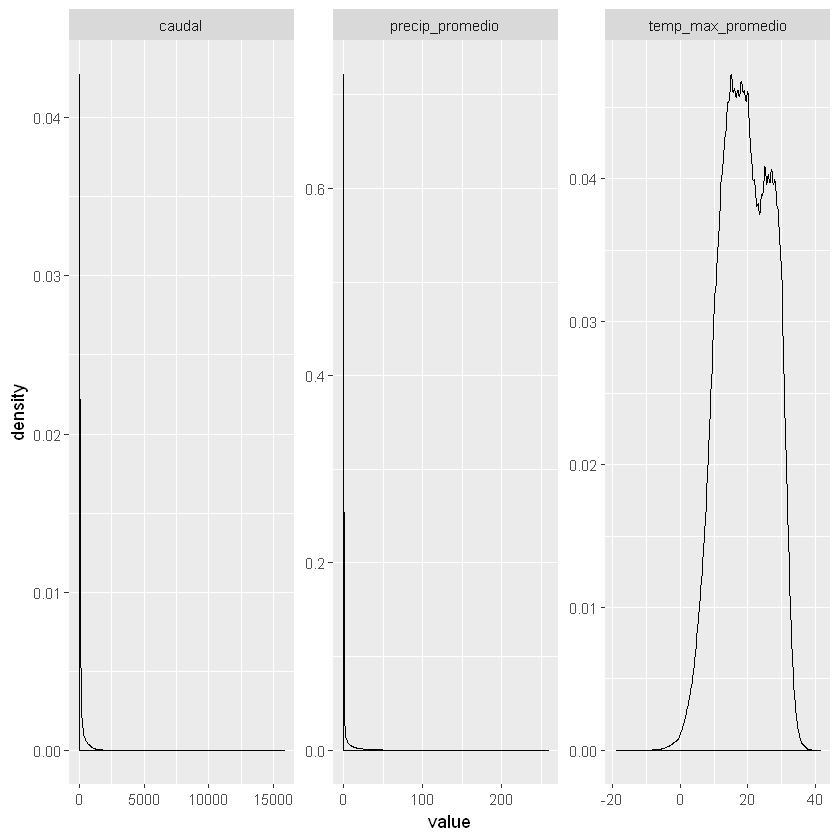

In [4]:
cuencas %>%
    select (c(13, 16, 17))%>% 
    na.omit()%>%
    melt() %>% 
    ggplot(aes(x = value)) +
     geom_density()+
     facet_wrap( ~ variable, scale = "free", nrow = 1)

Las distribuciones del caudal y la precipitación promedio son sesgadas a la izquierda mientras que la temperatura parece seguir una distribución bimodal.

### Plots de precipitación, temperatura y caudal

Plots de precipitación, temperatura y caudal

a. Escribir una función que tome como input una estación y haga plot de los datos para una columna. Debiese tener estos argumentos:

def time_plot_una_estacion(codigo_estacion, columna, fecha_min, fecha_max):


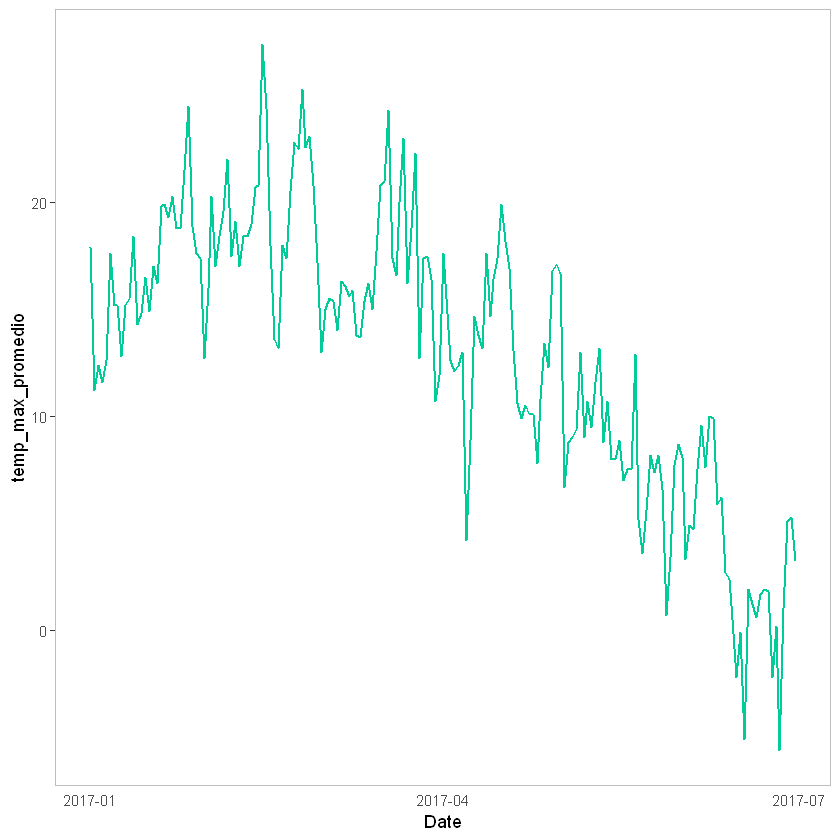

In [5]:
time_plot_una_estacion <- function(codigo_estacion, columna, fecha_min, fecha_max){
    x<- codigo_estacion #renombramos el valor ingresado como x para evitar confusión con el nombre del factor
    cuencas %>% 
    mutate(fecha = as.Date(cuencas$fecha, format = "%Y-%m-%d")) %>% #convertimos la columna fecha a tipo fecha
    filter(.$fecha >= fecha_min & .$fecha <= fecha_max) %>% #filtramos por las fechas que ingresen a la función
    filter(codigo_estacion == x) %>% #filtramos por el código de estación que ingresen a la función
    na.omit() %>% #omitimos los NAs
    ggplot(aes(x = .$fecha, y = .[,columna])) + #hacemos el plot con la columna que ingresen a la función
    geom_line(col="#00cc99", size = 0.6) + #cambiamos grosor y color de la línea
    theme(axis.ticks.x = element_blank(),
          panel.background = element_blank(),
          panel.border = element_rect(fill = NA,colour = "grey"))+ #cambiamos el color del borde del panel
    scale_x_date(date_labels = "%Y-%m") + #convertimos el eje x a fecha con formato año-mes
    xlab("Date") + ylab(columna)
}

#Ejemplo
time_plot_una_estacion("11335002", "temp_max_promedio", "2017-01-01", "2017-12-01")

b. Ahora escribir una función que haga plots de varias columnas, para poder visualizar caudal, precipitación y temperatura al mismo tiempo. Como las series están en diferentes escalas, sugerimos normalizarlas antes de hacer el plot (por ejemplo, dividiendo por la primera observación de cada serie)

def time_plot_estaciones_varias_columnas(codigo_estacion, columnas, fecha_min, fecha_max):


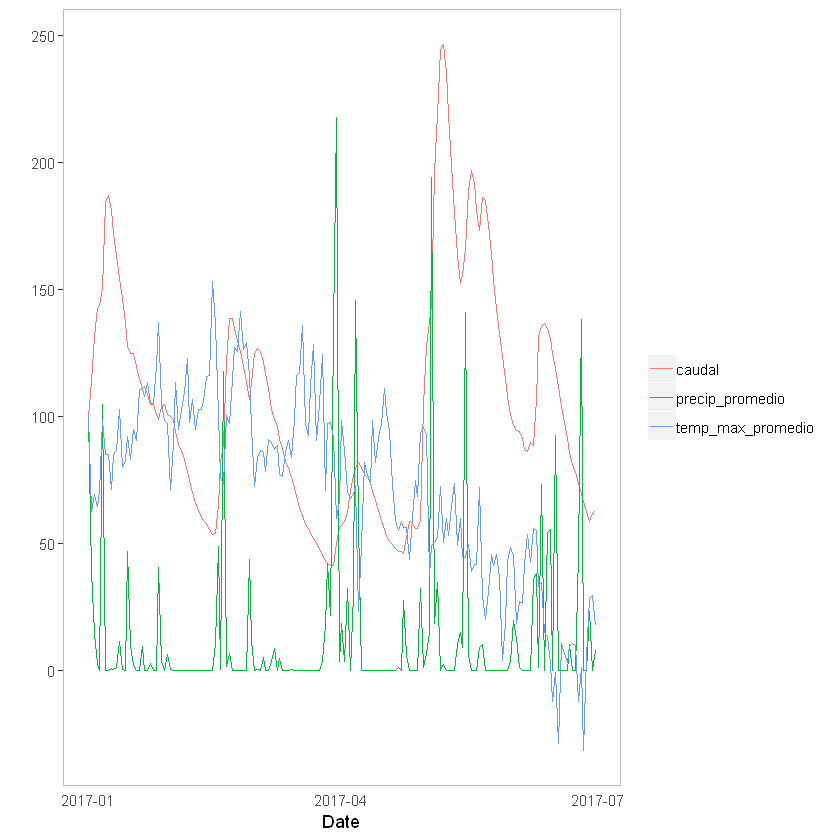

In [6]:
time_plot_varias_columnas <- function(codigo_estacion, columnas, fecha_min, fecha_max){
  x<- codigo_estacion #renombramos el valor ingresado como x para evitar confusión con el nombre del factor
  funcion <- cuencas[c("codigo_estacion", columnas, "fecha")]  #Elejimos las columnas de interés
  funcion <- funcion %>% 
    mutate(fecha = as.Date(.$fecha, format = "%Y-%m-%d")) %>% #convertimos la columna fecha a tipo fecha
    filter(.$fecha >= fecha_min & .$fecha <= fecha_max) %>% #filtramos por las fechas que ingresen a la función
    arrange(.$fecha) %>% #ordenamos por fecha
    filter(codigo_estacion == x) #filtramos por el código de estación que ingresen a la función
    for(i in columnas){ #creamos un loop que itera por cuántas columnas ponga la persona
      varname <-  i     #asignamos i como nombre de la variable
      funcion <- funcion %>%
        mutate(!!varname := funcion[, i]*100/funcion[1, i]) #convertimos la variable i para normalizar a 100 toda la columna por su primer valor
    }
  
  funcion %>% 
    melt(id= c("codigo_estacion", "fecha")) %>% #convertimos las variables "columnas" en formato largo, dejando fijas codigo_estacion y fecha
    ggplot(aes(x = .$fecha, y = value, col = variable)) + 
    geom_line()+
    theme(axis.ticks.x = element_blank(),
          panel.background = element_blank(),
          panel.border = element_rect(fill = NA,colour = "grey"), #cambiamos el color del borde del panel
          legend.title = element_blank())+ #eliminamos el título de la leyenda 
    scale_x_date(date_labels = "%Y-%m") + #convertimos el eje x a fecha con formato año-mes
    xlab("Date") + ylab("")
} #Limitaciones de la función: si el valor inicial de la columna es cero no funciona
 
#Ejemplo
time_plot_varias_columnas("11335002", c("caudal", "precip_promedio", "temp_max_promedio"), "2017-01-01", "2017-12-01")

### Variables extremas

Crea tres variables llamadas:

    ● caudal_extremo
    ● temp_extremo
    ● precip_extremo

Dichas variables toman valor 1 un día si el caudal/temperatura/precipitación (según sea el caso) observado ese día es extremo. Esto significa que es mayor de lo "esperado". Para capturar esta idea, el valor de caudal, por ejemplo, toma valor 1 si está sobre el percentil 95 de ese caudal para esa estación del año (Verano, Primavera, Otoño, Invierno). Toma valor 0 cuando está bajo ese percentil.

En otras palabras, para cada estación de medición y para cada estación del año, debes considerar la distribución histórica de caudal/ temperatura/ precipitación para elegir ese percentil 95. Esta medida toma en cuenta la estacionalidad, pues, por ejemplo, una temperatura de 25 grados en invierno puede ser extrema, pero en verano es normal. También toma en cuenta que cada cuenca (o estación) es diferente. Lo que es extremo para una cuenca no lo es para la otra.

In [7]:
#Tomaremos estas fechas como las estaciones
#Verano: desde el 21 de diciembre (solsticio) al 20 de marzo (equinoccio).
#Otoño: desde el 20 de marzo (equinoccio) al 21 de junio (solsticio).
#Invierno: desde el 21 de junio (solsticio) al 21 de septiembre (equinoccio).
#Primavera: desde el 21 de septiembre (equinoccio) al 21 de diciembre (solsticio).

#Creamos una columna con las estaciones
estaciones <- cuencas %>% 
  mutate(fecha = as.Date(cuencas$fecha, format = "%Y-%m-%d")) %>% #convertimos la columna fecha a tipo fecha
  mutate(estaciones = ifelse(as.Date(format(.$fecha, format = "%m-%d"), format = "%m-%d") 
                         %in% c(as.Date("03-01", format = "%m-%d"):
                                          as.Date("06-21", format = "%m-%d")), "Otoño",
                  ifelse(as.Date(format(.$fecha, format = "%m-%d"), format = "%m-%d")
                         %in% c(as.Date("06-22", format = "%m-%d"):
                                          as.Date("09-21", format = "%m-%d", )), "Invierno",
                  ifelse(as.Date(format(.$fecha, format = "%m-%d"), format = "%m-%d")
                         %in% c(as.Date("09-22", format = "%m-%d"):
                                          as.Date("12-21", format = "%m-%d")), "Primavera", 
                         "Verano")))) #usamos el comando mutate para crear la columna estaciones y con ifelse creamos las varias condiciones para clasificar cada estación


In [8]:
#Creamos las variables: caudal_extremo, temp_extremo y precip_extremo
percentil95 <-  estaciones %>% 
  mutate(codigo_cuenca = as.factor(as.numeric(codigo_cuenca))) %>% #convertimos la columna codigo_cuenca a factor
  group_by(codigo_estacion, estaciones) %>% #agrupamos por estación
  na.omit() %>% #omitimos los NAs
  mutate(caudal_95 = quantile(caudal, .95), #creamos columnas con que tengan el valor del percentil 95 para las 3 variables
         temp_95 = quantile(temp_max_promedio, .95),
         precip_95 = quantile(precip_promedio, .95)) %>% 
  ungroup() %>% # desagrupamos
  mutate(caudal_extremo =ifelse(caudal > caudal_95, 1, 0), #creamos las nuevas variables usando ifelse y la condición de ser mayor al percentil 95
         temp_extremo = ifelse(temp_max_promedio > temp_95, 1, 0),
         precip_extremo = ifelse(precip_promedio > precip_95, 1, 0))

#### ¿Les parece razonable esta medida para capturar algo “extremo”? ¿Usarían otra? ¿Cuál? (Solamente descríbanla, no la codifiquen! Vamos a usar la definición de Spike para esta desafío)

También usaría los valores estremos que están por debajo del 5% 

### Caudal extremo

Análisis de la variable caudal_extremo en las diferentes cuencas

In [44]:
cuencas %>%  
    summarise(n_distinct(codigo_cuenca)) #con esto podemos ver la cantidad de distintas cuencas que tenemos

n_distinct(codigo_cuenca)
29


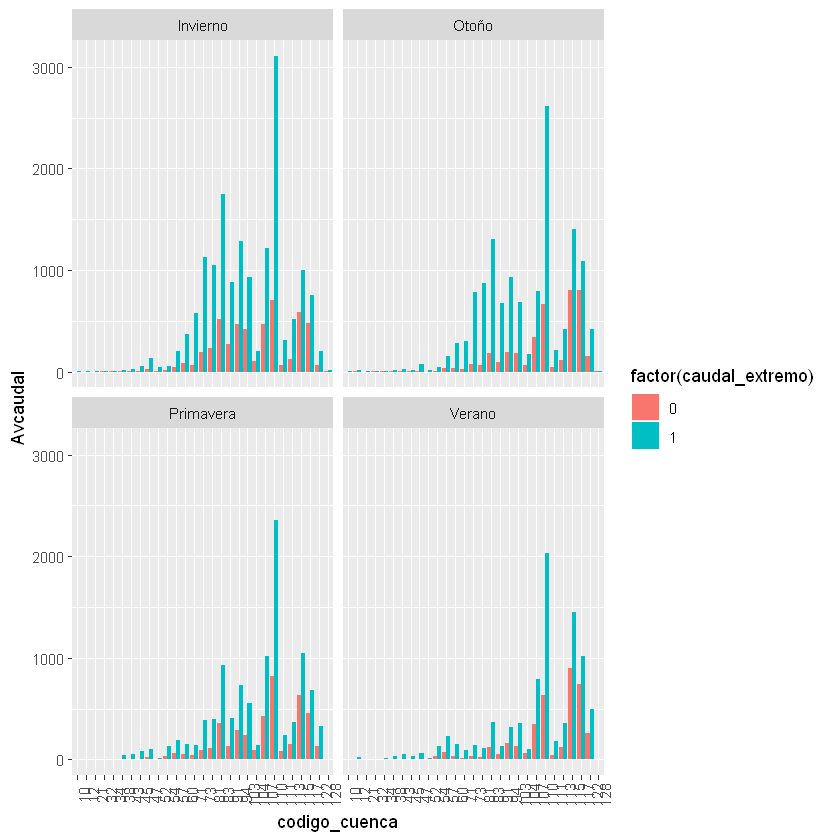

In [9]:
percentil95 %>%
  mutate(caudal_extemo = as.factor(caudal_extremo)) %>% #convertimos caudal_extremo en factor
  group_by(codigo_cuenca, estaciones, caudal_extremo) %>% #agrupamos las variables de interés
  summarise(Avcaudal=mean(caudal))%>%  #calculamo el promedio del caudal
  ggplot(aes(x = codigo_cuenca, y = Avcaudal, fill =factor(caudal_extremo)))+ 
  geom_bar(stat = "identity", position = "dodge")+ #dodge nos permite separar las barras para caudal_extremo igual a 1 y 0
  theme(axis.text.x = element_text(angle = 90))+ #colocamos el texto del eje x en vertical 
  facet_wrap(~estaciones, scales = "fixed", nrow = 2) #dividimos por paneles según estaciones, con la escala de los ejes fijos y dispuestos en dos filas 

#### Analicen la variable caudal_extremo. Los comportamientos en diferentes cuencas son muy diferentes?

Sí, las cuencas son bastante diferentes, unas con relativamente poco caudal en comparación con otras. También podemos ver en el gráfico que una misma cuenca puede tener comportamientos de caudal extremo incluso en la misma estación del año. Podemos ver que en algunos casos el promedio del caudal es más del doble para una misma cuenca y estación del año, al comparar caudal_extremo igual a 1 e igual a 0.

### Porcentaje de eventos extremos a través del tiempo

Hagan un plot del porcentaje de eventos extremos a través del tiempo (caudal_extremo, temp_extremo, precip_extremo). 

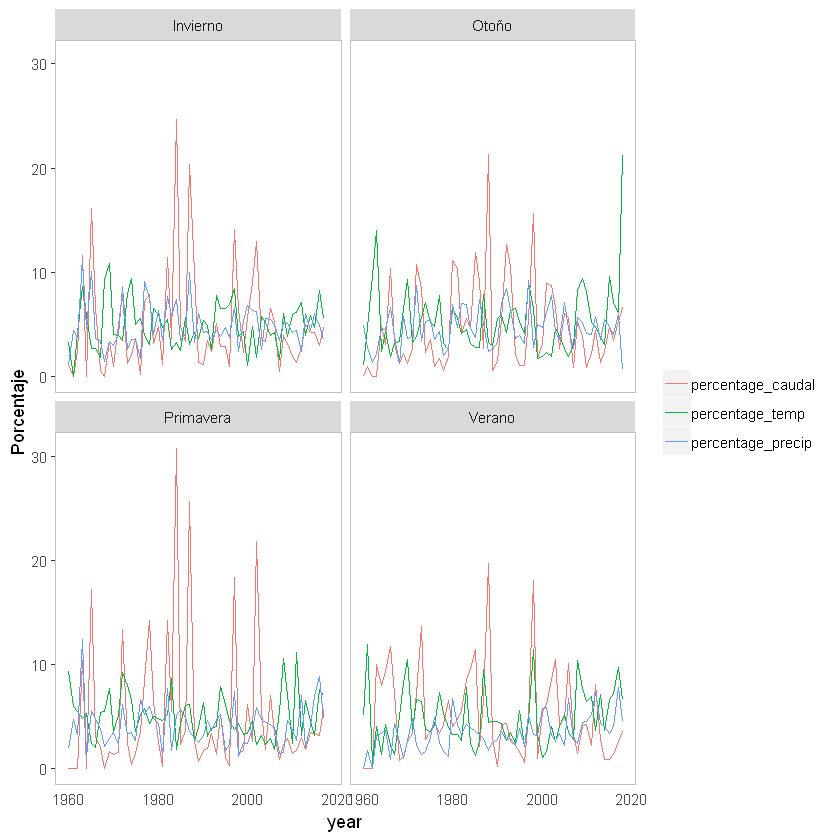

In [10]:
percentil95  %>% 
  mutate(year = lubridate::year(fecha), 
        month = lubridate::month(fecha), 
        day = lubridate::day(fecha)) %>% 
  group_by(year, estaciones) %>%          #agrupamos según nuestras variables de interés
  summarise(percentage_caudal =(sum(caudal_extremo)/n())*100, #pasamos las variables de interés a porcentaje
            percentage_temp =(sum(temp_extremo)/n())*100,
            percentage_precip =(sum(precip_extremo)/n())*100) %>%
  melt(id= c("year", "estaciones")) %>% #convertimos las variables "columnas" en formato largo, dejando fijas año y estaciones
  ggplot(aes(x = year, y = value, col = variable))+
  geom_line()+ 
  theme(axis.ticks.x = element_blank(),
          panel.background = element_blank(),
          panel.border = element_rect(fill = NA, colour = "grey"), #cambiamos el color del borde del panel
          legend.title = element_blank())+ #eliminamos el título de la leyenda 
  facet_wrap(~estaciones, scales = "fixed", nrow = 2)+
  ylab("Porcentaje")

#### Se han vuelto más o menos comunes?

Es difícil poder sacar algún patrón claro, pero se puede observar que particularmente la temperatura ha mostrado un aumento en los últimos años, en otoño. También se puede observar que para primevera e invierno ha ido aumentando el porcentaje mínimo de eventos extremos para las 3 variables.

### Predicción de caudal extremo

Predicción de caudal extremo. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de un caudal extremo (la variable binaria caudal_extremo). Siéntete libre de generar variables adicionales y/o complementar con variables externas.

In [11]:
#Primero limpiamos el dataframe
percentil95_clean <- percentil95 %>% 
                      select(-c(3:5, 9:11, 14, 15, 19:21)) %>%     #sacamos las columnas que no nos interesan
                      mutate(year = lubridate::year(fecha),        #creamos columnas con la fecha dividida en mes, día y año
                            mes = lubridate::month(fecha), 
                            dia = lubridate::day(fecha)) %>% 
                      mutate(estaciones = as.factor(.$estaciones), #convertimos a factor las columnas de interés
                            caudal_extremo = as.factor(.$caudal_extremo), 
                            temp_extremo = as.factor(.$temp_extremo),
                            precip_extremo = as.factor(.$precip_extremo)) %>%
                      na.omit()
str(percentil95_clean)  #Nos aseguramos que todo esté correcto

Classes 'tbl_df', 'tbl' and 'data.frame':	1256478 obs. of  16 variables:
 $ X                : int  32 33 34 35 36 37 38 39 40 41 ...
 $ codigo_estacion  : int  4540001 4540001 4540001 4540001 4540001 4540001 4540001 4540001 4540001 4540001 ...
 $ altura           : int  310 310 310 310 310 310 310 310 310 310 ...
 $ latitud          : num  -30.7 -30.7 -30.7 -30.7 -30.7 ...
 $ longitud         : num  -71.1 -71.1 -71.1 -71.1 -71.1 ...
 $ fecha            : Date, format: "1965-08-19" "1965-09-05" ...
 $ caudal           : num  77 51.2 56.9 81.9 50.4 11.8 3.43 2.75 18.2 14.3 ...
 $ precip_promedio  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ temp_max_promedio: num  21.5 20.5 22 20.5 28.5 25 27.5 21 16.5 20.5 ...
 $ estaciones       : Factor w/ 4 levels "Invierno","Otoño",..: 1 1 3 3 3 4 2 2 1 1 ...
 $ caudal_extremo   : Factor w/ 2 levels "0","1": 2 2 1 2 1 1 1 1 1 1 ...
 $ temp_extremo     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ precip_extremo   : Factor w/ 2 levels "0","1": 1 1 1

In [12]:
set.seed(158) #Asignamos una semilla para poder reproducir los resultados

#Dividimos nuestra data en datos de entrenamiento del modelo y datos de prueba
train_subset <- percentil95_clean %>% 
                    sample_frac(.70) #En este caso dividiremos la data en 70%  de entrenamiento y el 30% de prueba 
test_subset <- anti_join(percentil95_clean, train_subset, by = 'X') #anti_join nos permite agarrar las filas que no corresponden al set de prueba usando como referencia la columna X que posee un número único para cada fila

In [13]:
#De las 16 variables eliminaremos las variables X, codigo_estacion, precip_extremo y temp_extremo
train <- train_subset %>% 
                  select(-c(1:3, 12:13))
test <- test_subset %>% 
                  select(-c(1:3, 12:13))
str(train)

Classes 'tbl_df', 'tbl' and 'data.frame':	879535 obs. of  11 variables:
 $ latitud          : num  -45.4 -51.2 -28.5 -35.6 -37.6 ...
 $ longitud         : num  -72.5 -72.5 -71 -71.8 -72.6 ...
 $ fecha            : Date, format: "2003-10-20" "2016-08-02" ...
 $ caudal           : num  221 2.94 1.55 118 107 7.92 31.5 8.35 419 1.84 ...
 $ precip_promedio  : num  0.5 0.0333 0 0 0 ...
 $ temp_max_promedio: num  12.9 4.9 28.5 21.1 20.5 ...
 $ estaciones       : Factor w/ 4 levels "Invierno","Otoño",..: 3 1 3 3 2 3 1 2 1 3 ...
 $ caudal_extremo   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ year             : num  2003 2016 2009 2009 1984 ...
 $ mes              : num  10 8 12 12 4 11 6 5 8 11 ...
 $ dia              : int  20 2 11 1 6 8 27 8 23 1 ...


In [14]:
#Calculamos la correlación entre nuestras variables para ver si hay alguna redundante
correlation <- train %>% 
    mutate(fecha = as.numeric(fecha), #convertimos estas columnas para calcular la correlación ya que solo acepta caracteres numéricos
           caudal_extremo = as.numeric(caudal_extremo)) %>%
    select(-7) %>% #Y quitamos de la matriz la variable estaciones
    cor()
round(correlation, 3)


,latitud,longitud,fecha,caudal,precip_promedio,temp_max_promedio,caudal_extremo,year,mes,dia
latitud,1.000,0.847,-0.168,-0.350,-0.136,0.238,0.000,-0.168,0.000,0.001
longitud,0.847,1.000,-0.116,-0.394,-0.161,0.104,-0.001,-0.116,0.000,0.001
fecha,-0.168,-0.116,1.000,0.110,0.008,-0.144,-0.034,1.000,-0.005,-0.002
caudal,-0.350,-0.394,0.110,1.000,0.194,-0.235,0.204,0.109,0.058,0.003
precip_promedio,-0.136,-0.161,0.008,0.194,1.000,-0.259,0.120,0.008,0.012,-0.001
temp_max_promedio,0.238,0.104,-0.144,-0.235,-0.259,1.000,-0.047,-0.141,-0.149,-0.005
caudal_extremo,0.000,-0.001,-0.034,0.204,0.120,-0.047,1.000,-0.034,0.027,0.010
year,-0.168,-0.116,1.000,0.109,0.008,-0.141,-0.034,1.000,-0.025,-0.004
mes,0.000,0.000,-0.005,0.058,0.012,-0.149,0.027,-0.025,1.000,0.010
dia,0.001,0.001,-0.002,0.003,-0.001,-0.005,0.010,-0.004,0.010,1.000


Ya que fecha y año son redundantes sacaremos la variable año. Latitud y longitud también son redundantes por lo que sacaremos la varible latitud

In [15]:
train_data <- train %>% 
                select(-c(1, 9))%>%     #sacamos las variables redundantes
                do(sample_n(., 200000)) #remuestree el subset para agarrar menos datos por la capacidad de mi laptop
test_data <- test %>% 
                select(-c(1, 9))%>%
                do(sample_n(., 85714)) #también se remuestreó preservando los porcentajes 70, 30.

Elegí utilizar el algoritmo de random forest ya que es uno de los más precisos, que puede manejar gran cantidad de datos,tanto categóricos como númericos y que no necesita de la transformación previa de los datos.

In [16]:
#Tiene que tener espacio suficiente en la RAM para correr el modelo
rf_caudal_extremo <- randomForest(
  caudal_extremo ~ .,
  data=train_data
)
rf_caudal_extremo


Call:
 randomForest(formula = caudal_extremo ~ ., data = train_data) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 3.12%
Confusion matrix:
       0    1  class.error
0 189977  147 0.0007731796
1   6087 3789 0.6163426488

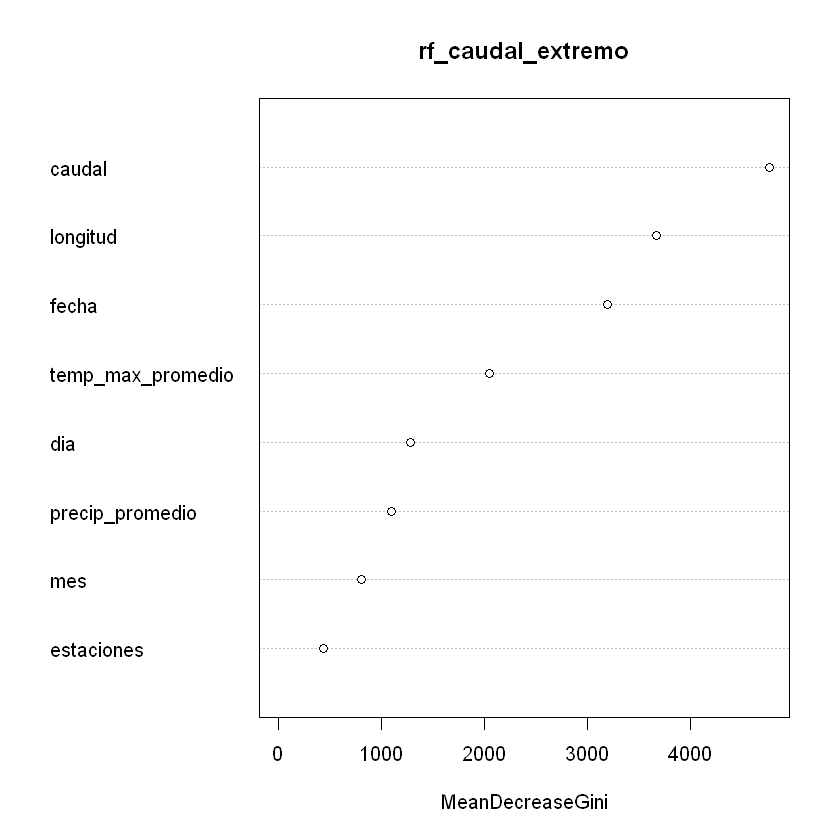

In [17]:
varImpPlot(rf_caudal_extremo) #podemos observar las variables más importantes

In [18]:
#Analizamos que tan bien predice el modelo los datos de prueba 
pred_caudal_extremo <-  predict(rf_caudal_extremo, newdata=test_data[-7])
table(test_data$caudal_extremo, pred_caudal_extremo) #Podemos ver la matriz de confusión de nuestras predicciones
prop.table(table(test_data$caudal_extremo, pred_caudal_extremo), margin = 1) #Podemos ver el porcentaje de precisión para los casos de caudal extremo igual a 1

   pred_caudal_extremo
        0     1
  0 81447    72
  1  2594  1601

   pred_caudal_extremo
               0            1
  0 0.9991167703 0.0008832297
  1 0.6183551847 0.3816448153

Ya que la variable caudal_extremo tiene poca representación de los valores extremos creé un dataset con que tuviesen un 19% de los datos como cauda_extremo igual a 1 y así que el modelo esté mejor entrenado para manejar estos casos.

In [19]:
f.sample <- function(a, percent) a[sample(nrow(a), nrow(a)*percent, replace = TRUE),]
train_balanced <- train %>% 
                    select(-c(1, 9)) #sacamos las variables redundantes
train_ex <- f.sample(train_balanced[train_balanced$caudal_extremo==1,], 0.9) #Elección de 90% de datos con caudal extremo = 1
train_no_ex <- f.sample(train_balanced[train_balanced$caudal_extremo==0,], 0.2) #Elección de 20% de datos con caudal extremo = 0
train_rf_balanced <- rbind(train_ex,train_no_ex) #Data de entrenamiento con 19% de datos con caudal extremo

test_balanced <- test %>% 
                    select(-c(1, 9))  #sacamos las variables redundantes
test_ex <- f.sample(test_balanced[test_balanced$caudal_extremo==1,], 0.9) #Elección de 90% de datos con caudal extremo = 1
test_no_ex <- f.sample(test_balanced[test_balanced$caudal_extremo==0,], 0.2) #Elección de 20% de datos con caudal extremo = 0
test_rf_balanced <- rbind(test_ex,test_no_ex) #Data de prueba con 19% de datos con caudal extremo


In [20]:
rf_balanced <- randomForest(
  caudal_extremo ~ .,
  data=train_rf_balanced
)

rf_balanced


Call:
 randomForest(formula = caudal_extremo ~ ., data = train_rf_balanced) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 2.51%
Confusion matrix:
       0     1 class.error
0 165754  1418 0.008482282
1   3764 35542 0.095761461

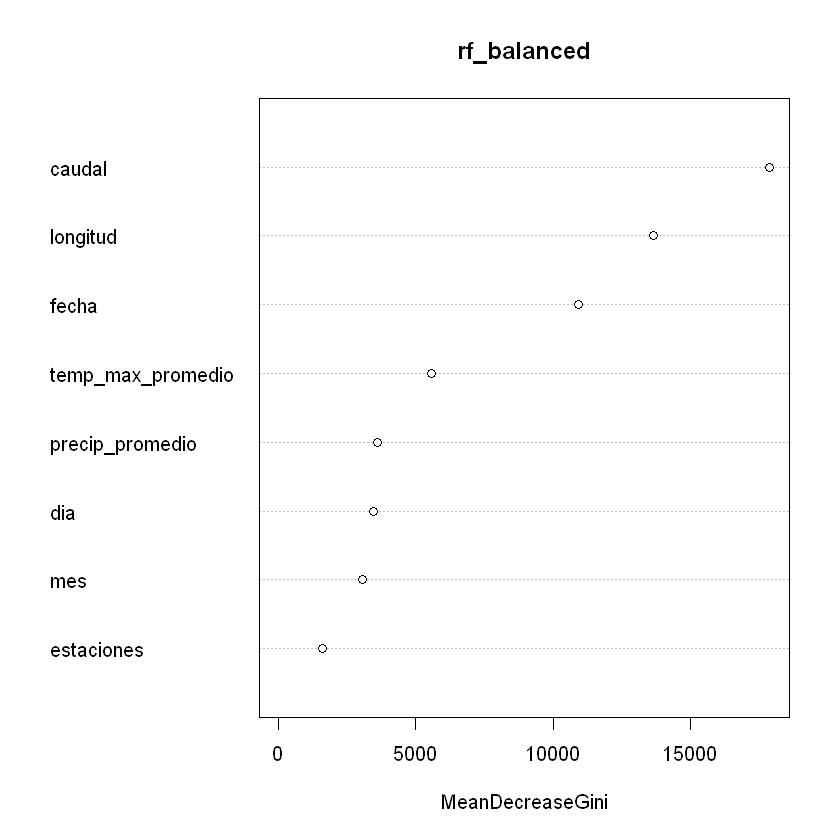

In [21]:
varImpPlot(rf_balanced) #podemos observar las variables más importantes

In [22]:
#Analizamos que tan bien predice el modelo los datos de prueba balanceados
pred_balanced_data <- predict(rf_balanced, newdata=test_rf_balanced[-7])
table(test_rf_balanced$caudal_extremo, pred_balanced_data) #Podemos ver la matriz de confusión de nuestras predicciones
prop.table(table(test_rf_balanced$caudal_extremo, pred_balanced_data), margin = 1) #Podemos ver el porcentaje de precisión para los casos de caudal extremo igual a 1

   pred_balanced_data
        0     1
  0 70884   724
  1  3934 13078

   pred_balanced_data
            0         1
  0 0.9898894 0.0101106
  1 0.2312485 0.7687515

In [27]:
#Analizamos que tan bien predice el modelo los datos de prueba originales.
pred_test_data <- predict(rf_balanced, newdata=test_data[-7])
table(test_data$caudal_extremo, pred_test_data) #Podemos ver la matriz de confusión de nuestras predicciones
prop.table(table(test_data$caudal_extremo, pred_test_data), margin = 1) #Podemos ver el porcentaje de precisión para los casos de caudal extremo igual a 1
auc(as.numeric(test_data$caudal_extremo), as.numeric(pred_test_data)) #medimos la precisión del modelo en general para nuestras predicciones

   pred_test_data
        0     1
  0 80656   863
  1  1016  3179

   pred_test_data
             0          1
  0 0.98941351 0.01058649
  1 0.24219309 0.75780691

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Area under the curve: 0.8736

##### ¿Qué datos podemos usar y cuáles no? Por supuesto, no podemos usar datos del futuro, pero ¿es lícito usar información del mismo día? ¿del día anterior? Todo depende de cómo propongas que el modelo se puede usar. Haz una propuesta de cómo usar tu modelo en la práctica (por ejemplo: una vez entrenado, voy a tomar los datos de XXX hasta el lunes y predecir para el día siguiente). Dada la propuesta, declara restricciones de información para caudal, temperatura y precipitación

El modelo está probado para manejar las varibles: longitud, fecha, caudal, precip_promedio, tem_max_promedio, estaciones, mes y día. Se puede utilizar información del mismo día para predecir si va a haber caudal_extremo ya que el modelo evalua las variables temporales: mes, día y fecha. 

### Análisis de resultados del modelo

#### a. Qué performance tiene el modelo? Qué métricas usaste para medir esa performance? Cuáles son las variables más importantes? Qué opinión te merecen los resultados?


El modelo de datos balanceados fue el más preciso para capturar eventos de caudal extremo. Esto se puede ver con la matriz de confusión y con el valor de 88% de área bajo la curva. El top tres de variables más importantes para este modelo son: el caudal, la longitud y la fecha.

#### b. Si quisiéramos capturar alrededor de un 70% de los eventos de caudales extremos. Cuál es la precisión de tu modelo con ese porcentaje de captura? Cuéntanos si te parece útil.

El modelo de datos balanceados captura un 76% de los eventos extremos. Y la precisión de mi modelo es de 97.49. Vale destacar que el modelo se hizo con datos de 133 estaciones y puede no funcionar de manera adecuada para otras condiciones.